In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
         
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
    
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        self.ax.set_aspect('equal')
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
     
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [3]:
%matplotlib notebook

## Functions for generating points
*Name of functions are self-explanatory*

In [4]:
import random
import math
from scipy.spatial import ConvexHull


def generate_cloud_of_points(xMin, xMax, yMin, yMax, numberOfPoints):
    arr = []
    for i in range(numberOfPoints):
        x = random.uniform(xMin,xMax)
        y = random.uniform(yMin,yMax)
        arr.append([x,y])
    arr = np.array(arr)
    return arr

def generate_cloud_of_points_circle_like(X, Y, R, numberOfPoints):
    arr = []
    accuracy = (math.pi*4)/numberOfPoints
    for i in range(numberOfPoints):
        ran = random.randint(0,numberOfPoints)
        r = random.uniform(0,R)
        x = r * math.sin(ran * accuracy) + X
        y = r * math.cos(ran * accuracy) + Y
        arr.append([x,y])
    arr = np.array(arr)
    return arr

def generate_line_of_points(xMin, xMax, height, numberOfPoints):
    arr = []
    for i in range(numberOfPoints):
        x = random.uniform(xMin,xMax)
        y = height + random.randint(0,1)
        arr.append([x,y])
    arr = np.array(arr)
    return arr

def generate_square(xMin,xMax,yMin,yMax,numberOfPoints):
    arr = []
    for _ in range(numberOfPoints//4): arr.append([xMin,random.uniform(yMin,yMax + 1)])
    for _ in range(numberOfPoints//4): arr.append([xMax,random.uniform(yMin,yMax + 1)])
    for _ in range(numberOfPoints//4): arr.append([random.uniform(xMin,xMax  +1),yMin])
    for _ in range(numberOfPoints//4): arr.append([random.uniform(xMin,xMax + 1),yMax])
    arr = np.array(arr)
    return arr

def generate_circle(X, Y, R, points=720):
    arr = []
    accuracy = (math.pi*4)/points
    for i in range(points):
        ran = random.randint(0,points)
        x = R * math.sin(ran * accuracy) + X
        y = R * math.cos(ran * accuracy) + Y
        arr.append([x,y])
    arr = np.array(arr)
    return arr

def create_circle(X, Y, R, points=720):
    arr = []
    accuracy = (math.pi*4)/points
    for i in range(points):
        x = R * math.sin(i * accuracy) + X
        y = R * math.cos(i * accuracy) + Y
        arr.append([x,y])
    return arr

*Quality-of-life improving functions*

In [5]:
def get_convex_cloud(points):
    hull = ConvexHull(points)
    simp = hull.simplices
    arr = []
    for i in range(len(simp)):
        if not simp[i][0] in arr: arr.append(simp[i][0])
        if not simp[i][1] in arr: arr.append(simp[i][1])
    arr2= []
    for index in arr:
        arr2.append(points[index])
    return arr2

def get_convex_cloud_lines(points):
    hull = ConvexHull(points)
    simp = hull.simplices
    arr = []
    for i in range(len(simp)):
        arr.append([points[simp[i][0]],points[simp[i][1]]])
    return arr

In [6]:
%matplotlib notebook
from scipy.spatial import ConvexHull, convex_hull_plot_2d

def dist(p1,p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

#function that finds first circle containing all points by selecting random 
def cicrle_containing_all_points(cloud):
    center_point = cloud[0]
    R = 0
    j = 0
    for i in range(1, len(cloud)):
        dis = dist(center_point, cloud[i])
        if R < dis:
            R = dis
            j = i
    circle = create_circle(center_point[0], center_point[1], R)
    
    
    return circle, j, R

def length_of_vector(vector):
    return math.sqrt(vector[0]**2 + vector[1]**2)

#this function returns how much we should move towards edge_point or middle_point on bisection each time, 
#the more steps the better the accuracy, but it might take longer
def step_vector(center_point, point, steps=1000):
    return [(point[0]-center_point[0])/steps, (point[1]-center_point[1])/steps]


def detect_if_point_is_outside_of_circle(point, X, Y, R, eps = 10**(-3)):
    x = point[0]
    y = point[1]
    
    return math.sqrt((x-X)**2 + (y-Y)**2) >= R - eps


def decrease_cricle(center_point, R, vector):
    center_point[0] += vector[0]
    center_point[1] += vector[1]
    R += -length_of_vector(vector)
    
    return R

def points_on_circle(center_point, R, points):
    on_circle = []
    
    for point in points:
        if(detect_if_point_is_outside_of_circle(point, center_point[0], center_point[1], R)):
            on_circle.append(point)
            
    return on_circle


def line_crossing_between_both_points(point1, point2):
    xa=point1[0]
    ya=point1[1]
    
    xb=point2[0]
    yb=point2[1]
    
    if xa-xb == 0:
        return 0, ya
    
    A = (ya-yb)/(xa-xb)
    B = ya - A*xa
    
    return A, B

def point_on_lines_cross(A1, B1, A2, B2):
    if A1-A2 == 0: return 0, B1
    x = (B2-B1)/(A1-A2)
    y = A1 * x + B1
    
    return [x, y]

## Algorithm
***ENG***

[ref link](https://www.nayuki.io/res/smallest-enclosing-circle/computational-geometry-lecture-6.pdf)

*Small observation: If we find circle containing all point on convex hull we will find circle containing all points*

1. Creat circle with center in "random" point (we will always take first generated point as "random") with R equal to his distance to farthest point on convex hull.
2. Move center point (but not literal point from cloud) towards point on circle until you find other point that lies on circle.
3. Now move center point towards bisection between points on the circle
4. End if either you find third point or center point reaches line crossing between both points  

*PL*
1. Stwórz koło w środku "losowego" punktu z chmury (będziemy brali pierwszy wylosowany punkt) i R równego jego odległości do najdalszego od niego punktu
2. Przesuwaj  środek okręgu w stronę punktu na okręgu zmniejszając R, aż do natrafienia innego punktu.
3. Gdy natrafisz na inny punkt zacznij poruszać się po ich symetralnej.
4. Program zakończy się gdy na okręgu znajdzie się 3 punkt lub środek okręgu znajdzie się na symetralnej dwóch punktów.

In [39]:
def find_minimal_cricle_inner_function(center_point, edge_point, R, points, scenes, cloud, accuracy, visualize_steps):
    vector = step_vector(center_point, edge_point, accuracy)
    A1, B1 = line_crossing_between_both_points(center_point, edge_point)
    
    #here we find second point that will lie on our circle
    while(len(points_on_circle(center_point, R, points)) == 1):
        R = decrease_cricle(center_point, R, vector)
        if visualize_steps:
            scenes.append(Scene([PointsCollection(cloud, color = "lightblue"),
                             PointsCollection(points, color = "green"),
                             PointsCollection([center_point], color = "red"),
                             PointsCollection(create_circle(center_point[0], center_point[1], R), color = 'red', marker = '.')],[]))
        
    
    #-------------------------------------------------------------------
    #here we have found second point (or more points) that shoud be on circle
    #and prepare to move towards middle point on bisection between those points
    
    on_circle = points_on_circle(center_point, R, points)
    
    A2, _ = line_crossing_between_both_points(on_circle[0], on_circle[1])

    if A2 != 0: A2 = -1/A2
    
    point_in_between = [(on_circle[0][0]+on_circle[1][0])/2, (on_circle[0][1]+on_circle[1][1])/2]
    
    B2 = point_in_between[1] - A2*point_in_between[0]
    
    center_point = point_on_lines_cross(A1,B1,A2,B2)
    
    R = dist(center_point, on_circle[0])
    
    #--------------------------------------------------------------------
    #here we go towards poin on segment that lies on bisection
    
    vector = step_vector(center_point, point_in_between, accuracy)
    steps = accuracy
    step = 0
    while(len(points_on_circle(center_point, R, points)) == 2):
        if(step == steps): break
        _ = decrease_cricle(center_point, R, vector)
        R = dist(center_point, on_circle[0])
        if(visualize_steps):
            scenes.append(Scene([PointsCollection(cloud, color = "lightblue"),
                             PointsCollection(points, color = "green"),
                             PointsCollection([center_point], color = "red"),
                             PointsCollection(create_circle(center_point[0], center_point[1], R), color = 'red', marker = '.')],[]))
        step += 1
        
    on_circle = points_on_circle(center_point, R, points)
    
    if len(on_circle) == 2:
        return R, on_circle, center_point
    
    
    #---------------------------------------------------------------------
    #the new center_point lies on crossing between two bisections between three points on circle
    
    A1, _ = line_crossing_between_both_points(on_circle[0], on_circle[1])
    A2, _ = line_crossing_between_both_points(on_circle[1], on_circle[2])
    
    if A1 != 0: A1 = -1/A1
    if A2 != 0: A2 = -1/A2
    
    point_in_between1 = [(on_circle[0][0]+on_circle[1][0])/2, (on_circle[0][1]+on_circle[1][1])/2]
    point_in_between2 = [(on_circle[1][0]+on_circle[2][0])/2, (on_circle[1][1]+on_circle[2][1])/2]
    
    B1 = point_in_between1[1] - A1*point_in_between1[0]
    B2 = point_in_between2[1] - A2*point_in_between2[0]
    
    center_point = point_on_lines_cross(A1,B1,A2,B2)
    
    R = dist(center_point, on_circle[0])
    
    return R, on_circle, center_point


def find_minimal_circle(cloud, use_convex, accuracy, visualize_steps):
    scenes = []
    
    
    cloud_convex = cloud.copy()
    cloud_convex_lines = []
    
    if use_convex:
        cloud_convex = get_convex_cloud(cloud.copy())
        cloud_convex_lines = get_convex_cloud_lines(cloud.copy())

    scenes.append(Scene([PointsCollection(cloud, color = "lightblue"), PointsCollection(cloud_convex, color="green")],
                        [LinesCollection(cloud_convex_lines, color="red")]))

    
    circle, j, R = cicrle_containing_all_points(cloud_convex.copy())

    center_point = cloud_convex[0].copy()
    edge_point = cloud_convex[j].copy()


    R, on_circle, center_point = find_minimal_cricle_inner_function(
                                center_point, edge_point, R, cloud_convex.copy(), scenes, cloud.copy(), accuracy, visualize_steps)
    
    print("R: ", R)
    print("Minimal area: ",math.pi * R**2)

    scenes.append(Scene([PointsCollection(cloud), 
                         PointsCollection([center_point], color='red'),
                         PointsCollection(create_circle(center_point[0], center_point[1], R), color = 'red', marker = '.'), 
                         PointsCollection(on_circle, color='black')], []))
    return scenes



## Main function where we execute algorithm for circle

R:  69.61788648959556
Minimal area:  15226.200409244528


<IPython.core.display.Javascript object>


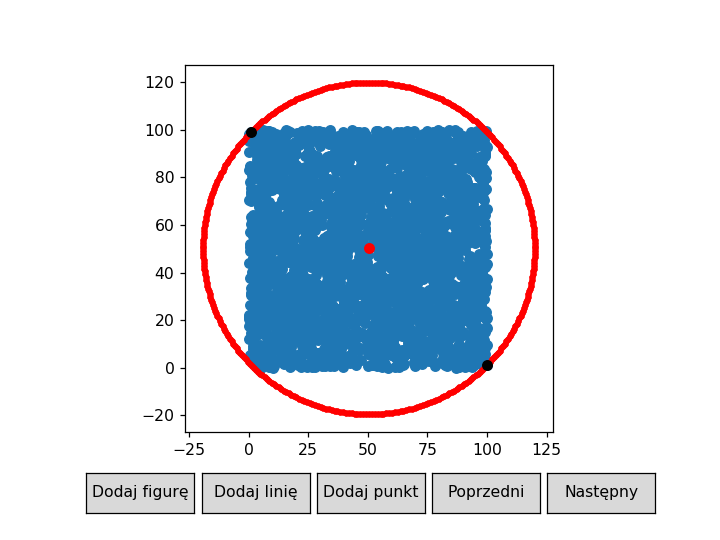

In [50]:
cloud = generate_cloud_of_points(0,100,0,100,3000)
# cloud = generate_square(0,100,0,100,100)
# cloud = generate_line_of_points(0,100,10,100)
# cloud = generate_cloud_of_points_circle_like(0,0,100,300)
# cloud = generate_circle(0,0,100,100)

accuracy = 100000 #if accuracy is high turn off visualize_steps
use_convex_hull = True
visualize_steps = False

scenes = find_minimal_circle(cloud, use_convex_hull, accuracy, visualize_steps)

plot = Plot(scenes)
plot.draw()

In [23]:
%matplotlib notebook

def get_move_vector(point):
    return [-point[0],-point[1]]
    
def get_convex_hull_order(cloud):
    hull = ConvexHull(cloud)
    arr = []
    for i in hull.vertices:
        arr.append(cloud[i])
    return arr

def rotate_point(point, sin, cos):
    xp = point[0] * (-cos) - point[1] * (sin)
    yp = point[1] * (-cos) + point[0] * (sin)
    
    return [xp,yp]

def create_rectangle(left, right, top, bot, sin, cos, move_vector):
    #this function creates rectangle containing all points for visualisation
    
    height = top[1]
    width = abs(right[0] - left[0])
    
    area = height * width
    
    perimiter = 2*height + 2*width
    
    #everything below this point is unneccesery for algorithm to work, but is mandatory for visualisation
    
    bottom_line_first_point = [left[0], 0]
    bottom_line_second_point = [right[0], 0]
    
    top_line_first_point = [left[0], top[1]]
    top_line_second_point = [right[0], top[1]]
    
    left_line_first_point = [left[0], 0]
    left_line_second_point = [left[0], top[1]]
    
    right_line_first_point = [right[0], 0]
    right_line_second_point = [right[0], top[1]]
    
    #=====================================================================================
    
    bottom_line_first_point = rotate_point(bottom_line_first_point, -sin, cos)
    bottom_line_second_point = rotate_point(bottom_line_second_point, -sin, cos)
    
    top_line_first_point = rotate_point(top_line_first_point, (-sin), cos)
    top_line_second_point = rotate_point(top_line_second_point, (-sin), cos)
    
    left_line_first_point = rotate_point(left_line_first_point, (-sin), cos)
    left_line_second_point = rotate_point(left_line_second_point, (-sin), cos)
    
    right_line_first_point = rotate_point(right_line_first_point, (-sin), cos)
    right_line_second_point = rotate_point(right_line_second_point, (-sin), cos)
    
    
    bottom_line_first_point[0] -= move_vector[0]
    bottom_line_first_point[1] -= move_vector[1]
    bottom_line_second_point[0] -= move_vector[0]
    bottom_line_second_point[1] -= move_vector[1]
    
    top_line_first_point[0] -= move_vector[0]
    top_line_first_point[1] -= move_vector[1]
    top_line_second_point[0] -= move_vector[0]
    top_line_second_point[1] -= move_vector[1]
    
    left_line_first_point[0] -= move_vector[0]
    left_line_first_point[1] -= move_vector[1]
    left_line_second_point[0] -= move_vector[0]
    left_line_second_point[1] -= move_vector[1]
    
    right_line_first_point[0] -= move_vector[0]
    right_line_first_point[1] -= move_vector[1]
    right_line_second_point[0] -= move_vector[0]
    right_line_second_point[1] -= move_vector[1]
    
    
    
    
    bottom_line = [bottom_line_first_point, bottom_line_second_point]
    
    top_line = [top_line_first_point, top_line_second_point]
    
    left_line = [left_line_first_point, left_line_second_point]
    
    right_line = [right_line_first_point, right_line_second_point]
    

    
    return [bottom_line,top_line,left_line,right_line], area, perimiter
    


def find_minimal_field_rectangle_containing_cloud(cloud):
    scenes = []
    points = cloud.copy()
    
    hull = get_convex_cloud(cloud)
    hull_order = get_convex_hull_order(cloud)
    hull_lines = get_convex_cloud_lines(cloud)
    scenes.append(Scene([PointsCollection(cloud, color="lightblue"),PointsCollection(hull, color = "green")],
                        [LinesCollection(hull_lines, color="red")]))
    
    scenes_with_min_area_and_perimiter = []
    min_area = 100000000000000000000
    min_perimiter = 100000000000000000000

    for i in range(len(hull_order)):
        #point a and point b
        a, b = hull_order[i], hull_order[i-1]
        #A, B in y=Ax+B
        A, B = line_crossing_between_both_points(a,b)
      
        projected_points = []
        move_vector = get_move_vector(a)
        
        
        tmp = b + move_vector
        
        #trigonometric functions for rotating points
        c = math.sqrt((tmp[0]**2 + tmp[1]**2))
        sin = tmp[1]/c
        cos = tmp[0]/c
        
        top = [0,0]
        right = [0,0]
        left = [0,0]
        
        
        for point in hull:
            new_point = point + move_vector
        
           
            xp = new_point[0] * (-cos) - new_point[1] * (sin)
            yp = new_point[1] * (-cos) + new_point[0] * (sin)
            
            
            new_point = [xp, yp]            
            
            
            if new_point[0] < left[0]: left = new_point
            if new_point[0] > right[0]: right = new_point
            if new_point[1] > top[1]: top = new_point
                
            
            projected_points.append(new_point.copy())
            
        change = False
        
        rectangle, area, perimiter = create_rectangle(left, right, top, [0.0,0.0], sin, cos, move_vector)
        
        if min_area > area:
            min_area = area
            change = True
        if min_perimiter > perimiter:
            min_perimiter = perimiter
            change = True
            
        if change:
            scenes_with_min_area_and_perimiter.append([area, perimiter, 
                            Scene([PointsCollection(hull, color = "green"),
                             PointsCollection([a], color = "red")],
                            [LinesCollection(get_convex_cloud_lines(cloud), color="red"), 
                            LinesCollection(rectangle, color = "gold")]
                        )])
        
        scenes.append(Scene([PointsCollection(hull, color = "green"),
                             PointsCollection([a], color = "red")],
                            [LinesCollection(get_convex_cloud_lines(cloud), color="red"), 
                            LinesCollection(rectangle)]
                        ))
    for i in range(len(scenes_with_min_area_and_perimiter)):
        if scenes_with_min_area_and_perimiter[i][0] == min_area:
            scenes.append(scenes_with_min_area_and_perimiter[i][2])
            print("Max area = ", min_area)
        if scenes_with_min_area_and_perimiter[i][1] == min_perimiter:
            scenes.append(scenes_with_min_area_and_perimiter[i][2])
            print("Max perimiter = ", min_perimiter)
    
    
    
    return scenes

## Algorithm for rectangle

***ENG***

1. Generate convex hull
2. For each edge in convex hull find supporting verticles top side of rectangle and do the same for left and right side. Bottom side is supported by edge in convex hull.
3. Choose rectangle with lowest are and lowest perimiter.

[Ref link](https://www.geometrictools.com/Documentation/MinimumAreaRectangle.pdf)

*PL*

1. Stwórz otoczkę wypukłą.
2. Weź każdą krawędź otoczki jako dolną jako dolny bok prostokąta i znajdź dla niej wierzchołki wspierające pozostałe boki prostokąta.
3. Z wszystkich możliwości wybierz taki prostokąt który ma najmniejsze pole i obwód.


Max perimiter =  3.5121390797830414
Max area =  0.562716


<IPython.core.display.Javascript object>


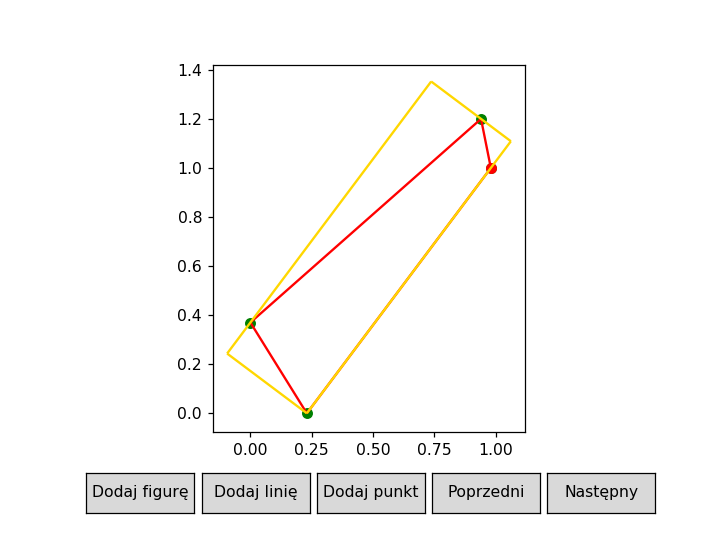

In [33]:
cloud = generate_cloud_of_points(0,100,0,100,300)
# cloud = generate_square(0,100,0,100,100)
# cloud = generate_line_of_points(0,100,10,100)
# cloud = generate_cloud_of_points_circle_like(0,0,100,300)
# cloud = generate_circle(0,0,100,100)




# case where rectangle with min area is different that rectangle with min perimiter
cloud = np.array([
    [0.23,0.0],
    [0.0,0.37],
    [0.98,1.0],
    [0.94,1.2]
])



scenes = find_minimal_field_rectangle_containing_cloud(cloud)

plot = Plot(scenes)
plot.draw()